# Overfitting and Regularization

In [5]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.options.mode.chained_assignment = None

# Bias vs Variance

See here: <a href="https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BC%D0%BF%D1%80%D0%BE%D0%BC%D1%96%D1%81_%D0%B7%D1%81%D1%83%D0%B2%D1%83_%D1%82%D0%B0_%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D1%96%D1%97">Компроміс зсуву та дисперсії</a>

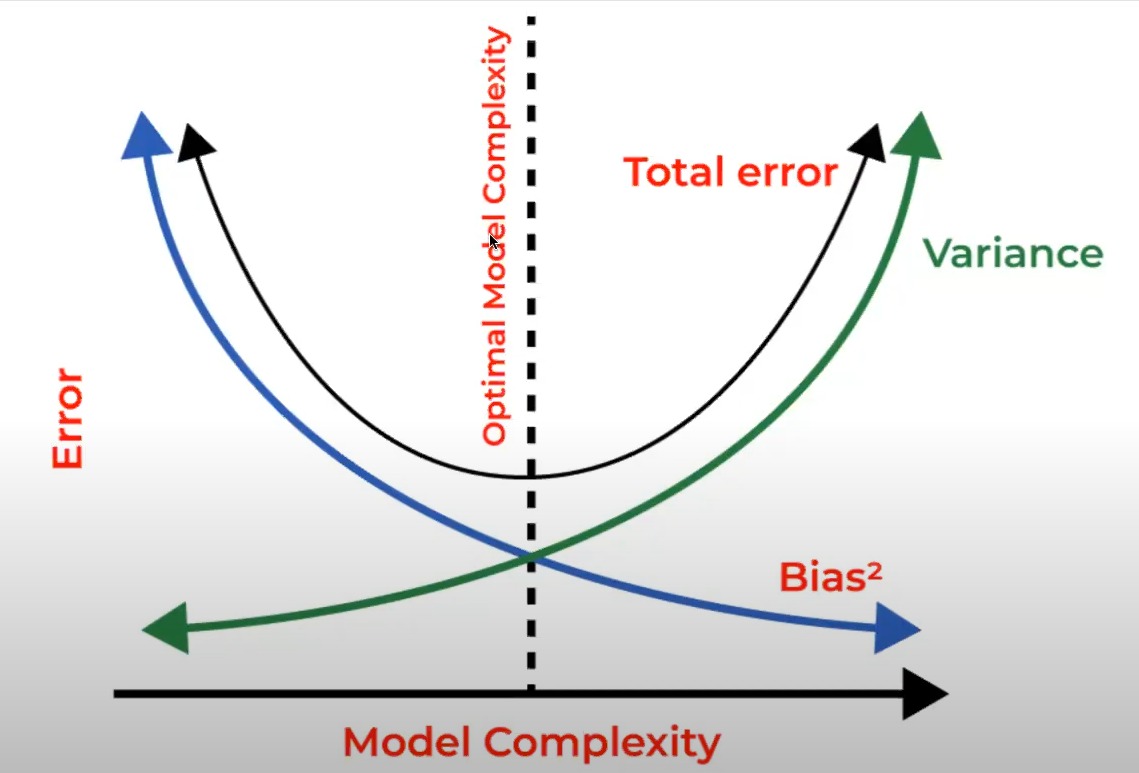

# Overfitting

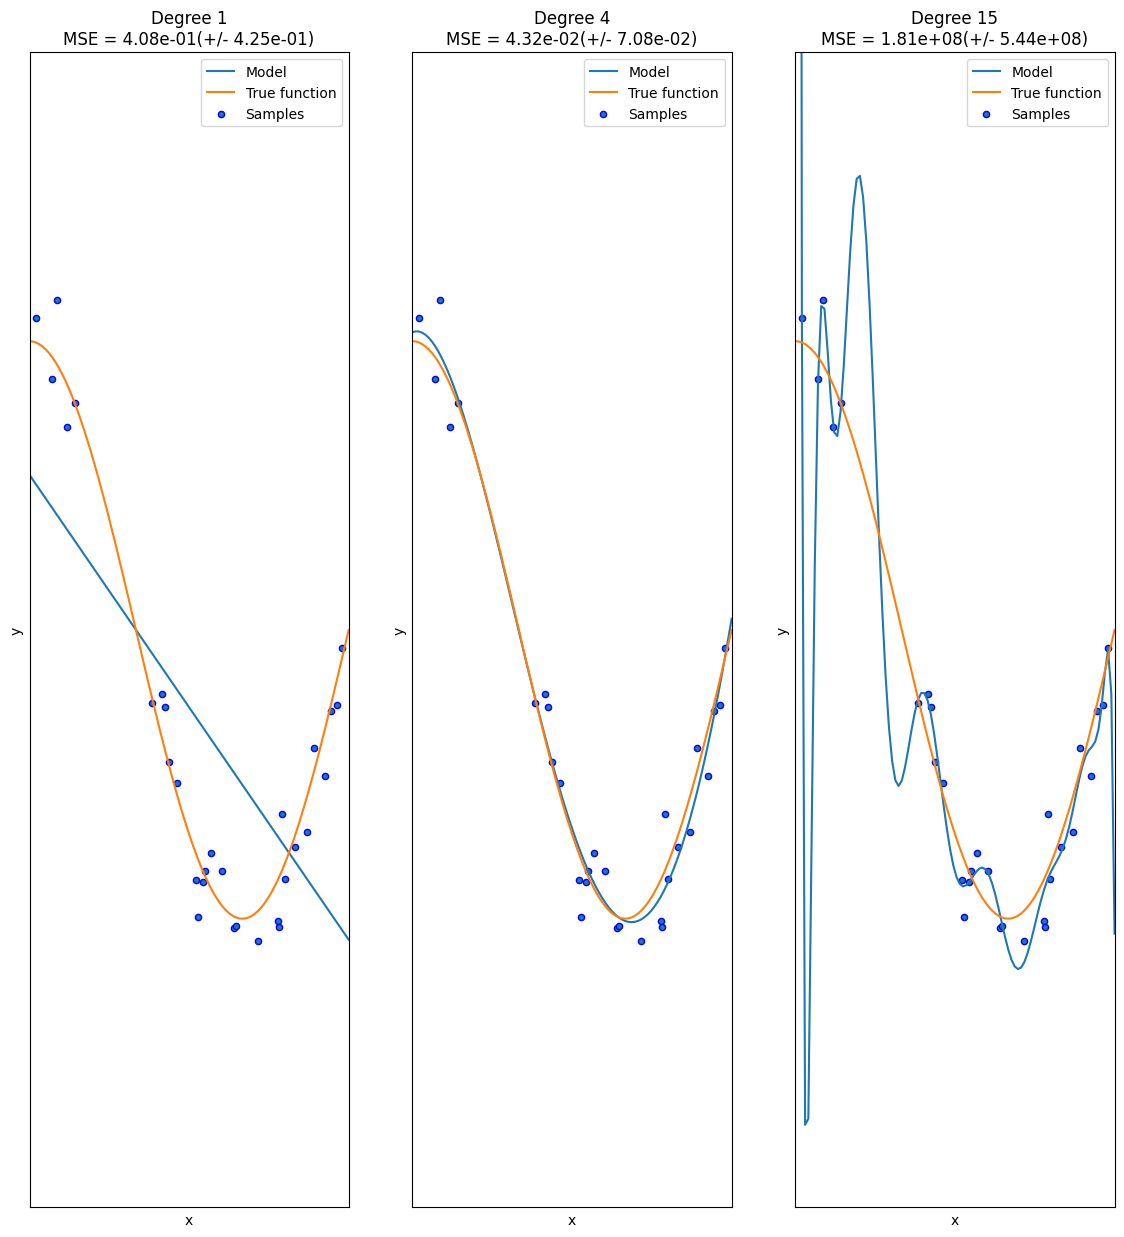

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

def true_fun(X):
    return np.cos(1.5*np.pi*X)

np.random.seed(0)

n_samples = 30
degrees = [1 ,4, 15]

X = np.sort(np.random.rand(n_samples)) 
y = true_fun(X) + np.random.randn(n_samples)*0.1

plt.figure(figsize=(14, 15))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks = (), yticks=())
    
    polynomal_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomal_features", polynomal_features),
            ("linear_regression", linear_regression)
        ]
    )
    
    pipeline.fit(X[:, np.newaxis], y)
    
    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolors='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

# Train-test split
We will use the Kaggle Food Demand Forecasting dat to demonstrate these major steps

* https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting/ (trains csv)

In [7]:
PATH = "../../data/food_demand"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
#test_data = pd.read_csv(os.path.join(PATH, 'test.csv'), index_col=0)

meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(drop=False)

meal_info_df[["category", "meal_id"]].groupby(["category"]).count()
df = df.merge(meal_info_df, on='meal_id', how='left')

df.head()


,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [8]:
#df.cuisine.unique()
df['cuisine'].unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [9]:
df_slice = df[(df['center_id']==55) & (df['cuisine']=="Thai")]
df_slice = df_slice[['checkout_price', 'num_orders']]

# sorted by checkout price
df_slice = df_slice.sort_values(by='checkout_price', axis=0, ascending=False)
df_slice.reset_index(inplace=True, drop=True)
df_slice

,checkout_price,num_orders
0,321.13,28
1,321.13,27
2,321.13,41
3,321.13,13
4,321.13,26
...,...,...
1274,80.54,54
1275,80.54,53
1276,80.54,55
1277,79.54,53


In [10]:
# train-test-split with sklearn
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_slice, shuffle=False, test_size=0.25)
train_data.head()

,checkout_price,num_orders
0,321.13,28
1,321.13,27
2,321.13,41
3,321.13,13
4,321.13,26


In [11]:
test_data.tail()

,checkout_price,num_orders
1274,80.54,54
1275,80.54,53
1276,80.54,55
1277,79.54,53
1278,79.54,55


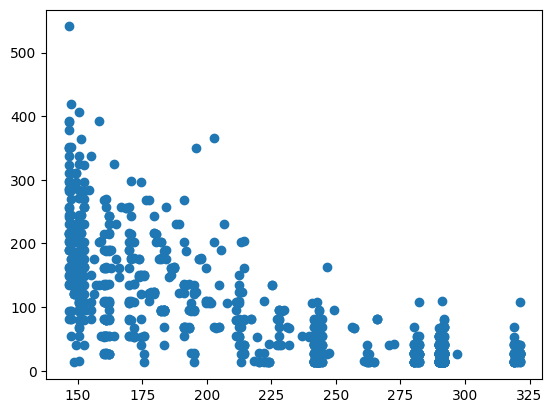

In [12]:
plt.scatter(train_data["checkout_price"], train_data['num_orders'])

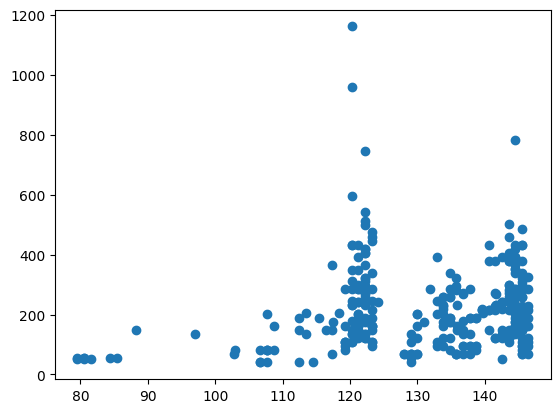

In [13]:
plt.scatter(test_data["checkout_price"], test_data["num_orders"])

In [14]:
from sklearn.linear_model import LinearRegression

x = train_data["checkout_price"].to_numpy().reshape(-1,1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x,y)

In [15]:
train_data["predictions"] = model.predict(x)

x_test = test_data['checkout_price'].to_numpy().reshape(-1,1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

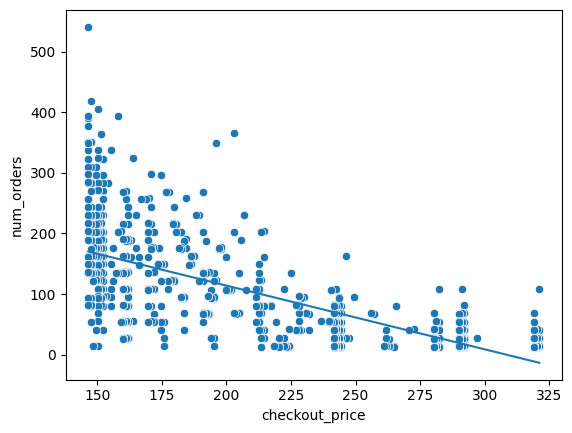

In [16]:
# Train
sns.scatterplot(x='checkout_price', y='num_orders', data = train_data)
sns.lineplot(data=train_data, x='checkout_price', y = 'predictions')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

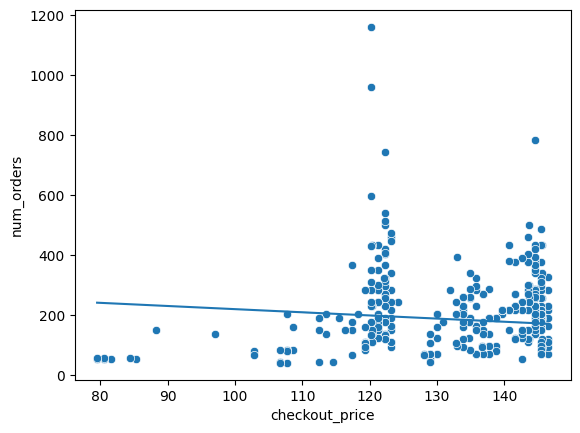

In [17]:
# Test
sns.scatterplot(x='checkout_price', y='num_orders', data =test_data)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error_train = mean_squared_error(train_data['num_orders'], train_data['predictions'])
print(f'Train {mean_squared_error_train=}')
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data['predictions'])
print(f'Test {mean_squared_error_test=}')

Train mean_squared_error_train=3606.2784562593893
Test mean_squared_error_test=20230.476494162875


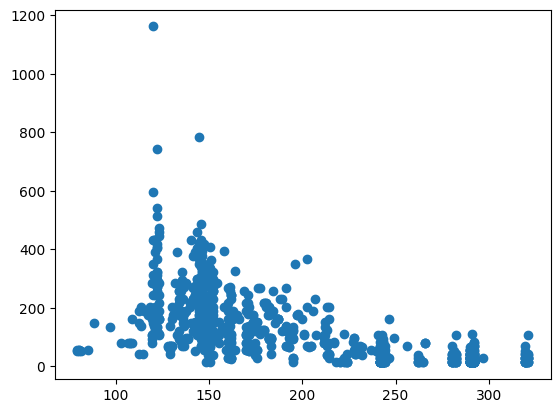

In [19]:
# Shuffle the data
train_data, test_data = train_test_split(df_slice, shuffle=True, test_size=0.25)

plt.scatter(train_data["checkout_price"], train_data['num_orders'])

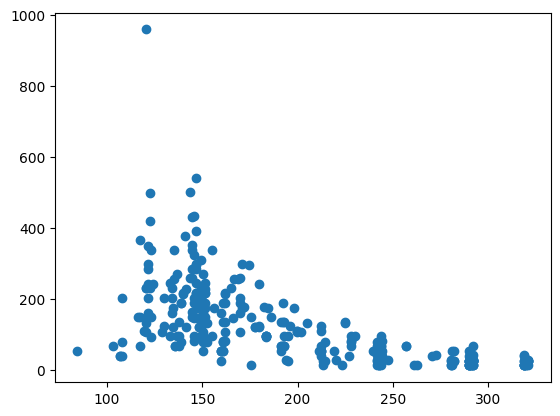

In [20]:
plt.scatter(test_data["checkout_price"], test_data["num_orders"])

In [21]:
x = train_data["checkout_price"].to_numpy().reshape(-1,1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x,y)
train_data["predictions"] = model.predict(x)

x_test = test_data['checkout_price'].to_numpy().reshape(-1,1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

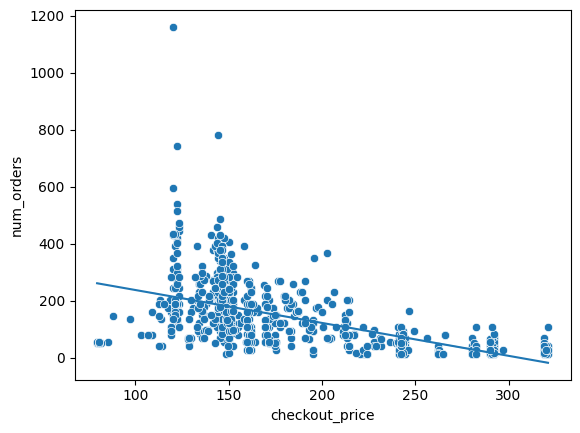

In [22]:
sns.scatterplot(x='checkout_price', y='num_orders', data = train_data)
sns.lineplot(data=train_data, x='checkout_price', y = 'predictions')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

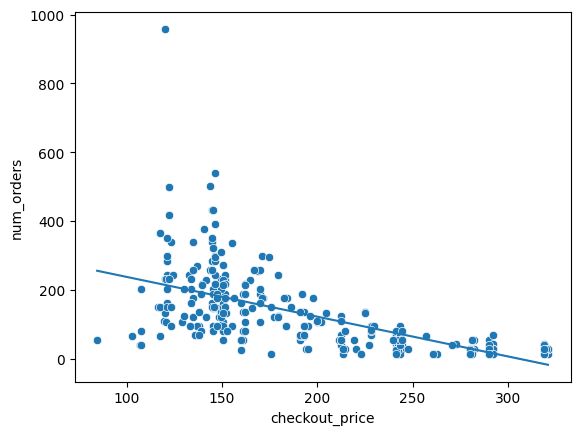

In [23]:
sns.scatterplot(x='checkout_price', y='num_orders', data = test_data)
sns.lineplot(data=test_data, x='checkout_price', y = 'predictions')

In [24]:
mean_squared_error_train = mean_squared_error(train_data['num_orders'], train_data['predictions'])
print(f'Train {mean_squared_error_train=}')
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data['predictions'])
print(f'Test {mean_squared_error_test=}')

Train mean_squared_error_train=7731.297071028298
Test mean_squared_error_test=7484.561595717113


# Cross Validation
https://scikit-learn.org/stable/modules/cross_validation.html

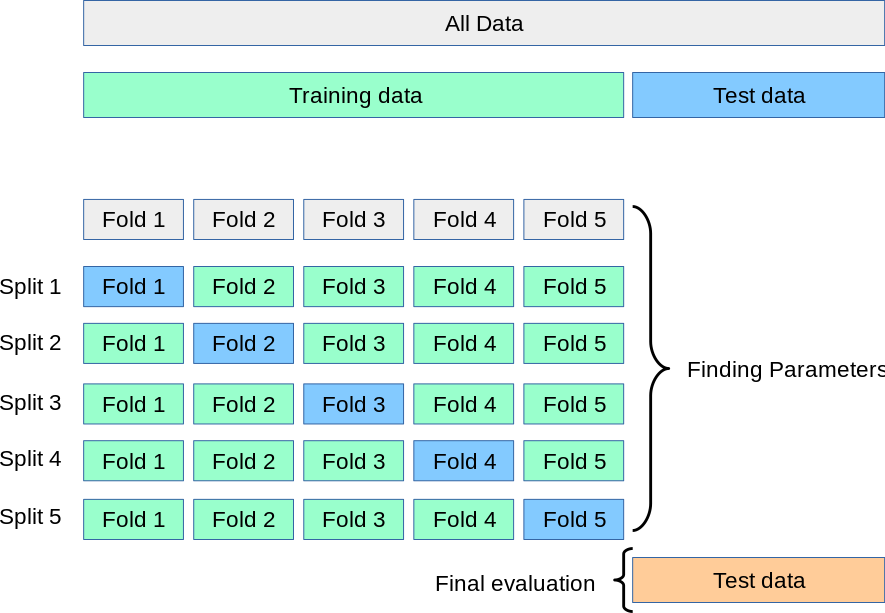

In [30]:
from sklearn import model_selection

X = range(10)

In [26]:
kf = model_selection.KFold(n_splits=5)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)
    
print()
    
kf = model_selection.KFold(n_splits=2, shuffle=True)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)

print()

kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=1)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)


[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]

[0 1 3 5 8] [2 4 6 7 9]
[2 4 6 7 9] [0 1 3 5 8]

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


In [31]:
X = range(12)

y = np.array([0]*6 + [1]*6)
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print(train_indices, test_indices)

[0 0 0 0 0 0 1 1 1 1 1 1]
[ 0  3  5  7  8 11] [ 1  2  4  6  9 10]
[ 1  2  4  6  9 10] [ 0  3  5  7  8 11]


In [33]:
y = np.array([0,1]*6)
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print(train_indices, test_indices)

[0 1 0 1 0 1 0 1 0 1 0 1]
[ 0  3  5  6 10 11] [1 2 4 7 8 9]
[1 2 4 7 8 9] [ 0  3  5  6 10 11]


In [34]:
ss = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
for train_indices, test_indices in ss.split(X):
    print(train_indices, test_indices)

[ 6  5  8 11  4  1  0  7 10] [3 9 2]
[ 3 11  6  2  8  9  4  5 10] [0 1 7]
[ 6  7  5 10  1  9  8  0  3] [ 2  4 11]
[ 6 11 10  0  4  5  9  3  2] [7 8 1]
[ 5  7  6 10  0 11  4  1  8] [2 3 9]
[ 4  7  8  5  6 10  3  0  9] [ 2 11  1]
[ 9  0 10  3  1  2 11  5  8] [4 6 7]
[ 4  0  9  1 11  7  2  6  8] [ 3  5 10]
[ 8  4  9  0  1  2 11  3 10] [5 7 6]
[ 9  4 10  8  7  1 11  2  3] [0 6 5]


In [39]:
X = range(10)
target = np.array([0]*5 + [1]*5)
print(target )
print()

sss = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.2)
for train_indices, test_indices in sss.split(X, target):
    print(train_indices, test_indices)


[0 0 0 0 0 1 1 1 1 1]

[2 5 4 1 6 7 9 3] [8 0]
[4 6 8 7 5 2 0 3] [9 1]
[7 8 4 6 0 1 3 9] [2 5]
[9 4 0 2 6 7 8 1] [5 3]


In [40]:
loo = model_selection.LeaveOneOut()

for train_indices, test_indices in loo.split(X):
    print(train_indices, test_indices)


[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


# Regularization

Ridge Regression: In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coeficients. 

Classic linear regression:
$$
\hat{y} = \beta[0] \times x[0] + \beta[1] \times x[1] + \dots + \beta[n] \times x[n] + b \quad \text{Eqn 1.1}
$$

Sum of squares in classic linear regression:
$$
\sum_{i=1}^{M} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{M} \left( y_i - \sum_{j=0}^{p} \beta_j \times x_{ij} \right)^2 \quad \text{Eqn 1.2}
$$

### Lasso (L1)
$$
L_{\text{Lasso}}(\hat{\beta}) = \sum_{i=1}^{n} (y_i - x_i \hat{\beta})^2 + \lambda \sum_{j=1}^{m} |\hat{\beta}_j|
$$

### Ridge (L2)

$$
SSE_{\text{L}_{\text{2}}} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{P} \beta_j^2
$$

